# Optimizing Stock Portfolio Allocation <a class='tocSkip'>

## Sang-Yun Oh <a class='tocSkip'>

## Installing Packages in Python

* Default package source for `pip` command is Python Package Index (PyPI)  
    e.g., https://pypi.org/project/yfinance/
* Can also install from github repository: 
    https://pypi.org/project/yfinance/

In [1]:
import pandas as pd
import numpy as np
import pickle
import cvxpy

## Introduction to Portfolio Theory

### Stock Prices vs. Returns 

* Model stock returns as random variables
* Returns depend on change in stock prices:  
    $$ R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1 $$

* Linear approximation of $\log(1+x)\approx x$ when $x$ is small. 
* Since daily stock returns are small,
$$ R_t \approx \log(1 + R_t) = \log\left(\frac{P_t}{P_{t-1}}\right) = \log(P_t) - \log(P_{t-1})$$

* Compute the log-returns then difference of log prices (converting data)

### Modeling Stock Returns

* In classical portfolio theory, stock returns are normally distributed
* Daily returns of two stocks: $R_A$ and $R_B$ of two stocks $A$ and $B$
* Jointly normally distributed: bivariate normal distribution: 
$$\begin{aligned}
\begin{pmatrix}
R_A\\ R_B
\end{pmatrix}
\sim
N\left(
\begin{pmatrix}
\mu_A\\ \mu_B
\end{pmatrix},
\begin{pmatrix}
\sigma_A^2 & \sigma_{AB}\\
\sigma_{AB} & \sigma_B^2
\end{pmatrix}
\right)
\end{aligned}$$

* Marginal distributions: 
$$R_A \sim N(\mu_A,\sigma_A^2) \text{, and } R_B \sim N(\mu_B,\sigma_B^2),$$
* Covariance and correlation are
$$\sigma_\text{AB} = \text{Cov}(R_A,R_B) \text{, and } \rho_\text{AB} = \frac{\sigma_\text{AB}}{\sigma_A\sigma_B}$$

### Modeling Portfolio Returns

* Two-stock portfolio: Return for the portfolio $R_p$ is 
$$R_p = R_A x_A + R_B x_B,$$
* Allocations: $x_A$ and $x_B$ are proportions of stocks $A$ and $B$ such that  
$$x_A + x_B = 1$$

* $R_p$ is also normally distributed with following mean and variance:
$$\begin{aligned}
\mu_p &= \text{E}(R_p) \\
    &= \text{E}(R_B)\, x_A + \text{E}(R_B)\, x_B\\
    &= \mu_A x_A + \mu_B x_B\\
\sigma_p^2 &= \text{Var}(R_p) \\
    &= \text{E}\left((R_p - \text{E}(R_p))^2\right) \\
    &= \sigma_A^2\,x_A^2 + \sigma_B^2\,x_B^2 + 2\sigma_{AB}x_A x_B.
\end{aligned}
$$
Note that $\sigma_{AB} = \rho_{AB}\sigma_A\sigma_B$.
* Distribution of the portfolio return is
$$ R_p \sim N(\mu_p, \sigma_p^2) $$

### Hedging Portfolio Risk

* Mean return ($\mu_p$): weighted average of returns
* Risk ($\sigma_p^2$):  Risk of $p$ can be decreased if $\rho<0$
* Hedge risk by having negatively correlated stocks

## Toy Example: Simulating $R_A$ and $R_B$

* $R_A\sim N(0.15, 0.1^2)$ and $R_B\sim N(0.1, 0.05^2)$
* Correlation: $\rho_{AB} = -0.15$
* Portfolio weight distributed evenly: i.e. $x_A = x_B = 0.5$

In [2]:
A = {'mu': 0.15, 'sig': 0.1,  'proportion': 0.5}
B = {'mu': 0.1,  'sig': 0.05, 'proportion': 0.5}

### Generate random returns

In [3]:
def simulate_returns(A, B, correlation, size=100):
    
    from numpy import sqrt
    from numpy.random import multivariate_normal
    from pandas import DataFrame
    
    # what could go wrong with rounding errors?
    assert(A['proportion'] + B['proportion'] == 1) 

    # construct bivariate normal random variable
    mu = [A['mu'], B['mu']]
    sigma = [[A['sig']**2, correlation*A['sig']*B['sig']],
             [correlation*A['sig']*B['sig'], B['sig']**2]]
    
    # get random observations
    R = multivariate_normal(mu, sigma, size)
    Rp = R[:,0]*A['proportion'] + R[:,1]*B['proportion']
    
    # simulated returns
    R = np.hstack((R, Rp.reshape((-1,1))))
    
    # theoretical properties of portfolio returns
    p = {
        'mu': A['mu']*A['proportion'] + B['mu']*B['proportion'],
        'sig': sqrt(
            A['sig']**2*A['proportion']**2 + B['sig']**2*B['proportion']**2 
            + 2*correlation*A['sig']*B['sig']*A['proportion']*B['proportion'])
        }
    
    return p, DataFrame(R, columns=['A', 'B', 'p'])

### Empirical Returns

In [4]:
A = {'mu': 0.15, 'sig': 0.1,  'proportion': 0.5}
B = {'mu': 0.1,  'sig': 0.05, 'proportion': 0.5}

p, R = simulate_returns(A, B, -0.9, 10000)

print('A: mean = %1.2f, std = %1.4f' % (R.A.mean(), R.A.std()))
print('B: mean = %1.2f, std = %1.4f' % (R.B.mean(), R.B.std()))
print('p: mean = %1.2f, std = %1.4f' % (R.p.mean(), R.p.std()))

print('cor(R_A, R_B) = %1.4f' % np.corrcoef(R.A, R.B)[1,0])

A: mean = 0.15, std = 0.1001
B: mean = 0.10, std = 0.0502
p: mean = 0.13, std = 0.0296
cor(R_A, R_B) = -0.8996


### Empirical Portfolio Returns

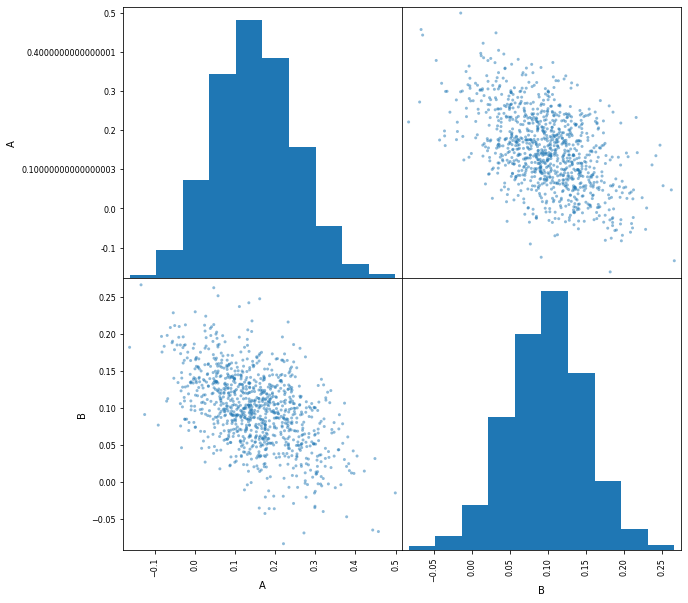

In [5]:
p, R = simulate_returns(A, B, -0.5, 1000)
pd.plotting.scatter_matrix(R.loc[:,['A','B']], figsize=(10,10));

### Theoretical returns

Calculate the volatility ($\sigma^2$) and expected returns ($\mu$):

In [6]:
print('A: mean = %1.2f, std = %1.4f' % (A['mu'], A['sig']))
print('B: mean = %1.2f, std = %1.4f' % (B['mu'], B['sig']))
print('p: mean = %1.2f, std = %1.4f' % (p['mu'], p['sig']))

A: mean = 0.15, std = 0.1000
B: mean = 0.10, std = 0.0500
p: mean = 0.12, std = 0.0433


### Independent Portfolio Theoretical returns

If stocks A and B were independent

In [7]:
p, R = simulate_returns(A, B, -0.9, 10000)
print('A: mean = %1.2f, std = %1.4f' % (A['mu'], A['sig']))
print('B: mean = %1.2f, std = %1.4f' % (B['mu'], B['sig']))
print('')
print('p: mean = %1.2f, std = %1.4f (if A and B are correlated )' % (p['mu'], p['sig']))
print('p: mean = %1.2f, std = %1.4f (if A and B are independent)' % (p['mu'], np.sqrt(0.5**2*A['sig']**2 + 0.5**2*B['sig']**2)))

A: mean = 0.15, std = 0.1000
B: mean = 0.10, std = 0.0500

p: mean = 0.12, std = 0.0296 (if A and B are correlated )
p: mean = 0.12, std = 0.0559 (if A and B are independent)


#### Empirical (Data) Properties 

In [8]:
print('A: mean = %1.2f, std = %1.4f' % (R.A.mean(), R.A.std()))
print('B: mean = %1.2f, std = %1.4f' % (R.B.mean(), R.B.std()))
print('p: mean = %1.2f, std = %1.4f' % (R.p.mean(), R.p.std()))
print('corr(A, B) = %1.4f' % np.corrcoef(R.A, R.B)[0,1])

A: mean = 0.15, std = 0.1003
B: mean = 0.10, std = 0.0497
p: mean = 0.13, std = 0.0297
corr(A, B) = -0.9022


### Efficient frontier of portfolios

* Consider all values of $x_A$ and $x_B$

* For each combination, compute $\mu_p$ and $\sigma_p^2$.

In [9]:
xa = np.linspace(-1, 2, num=101)
pf = pd.DataFrame({'xa':xa, 'xb':1-xa})

# pf, R = simulate_returns(A, B, -0.5, 10000)

corr = -0.5
pf['mu'] = A['mu'] * pf.xa + B['mu'] * pf.xb
pf['sig2'] = ((A['sig']**2 * pf.xa**2) + (B['sig']**2 * pf.xb**2) + (2 * corr * A['sig'] * B['sig'] * pf.xa * pf.xb))

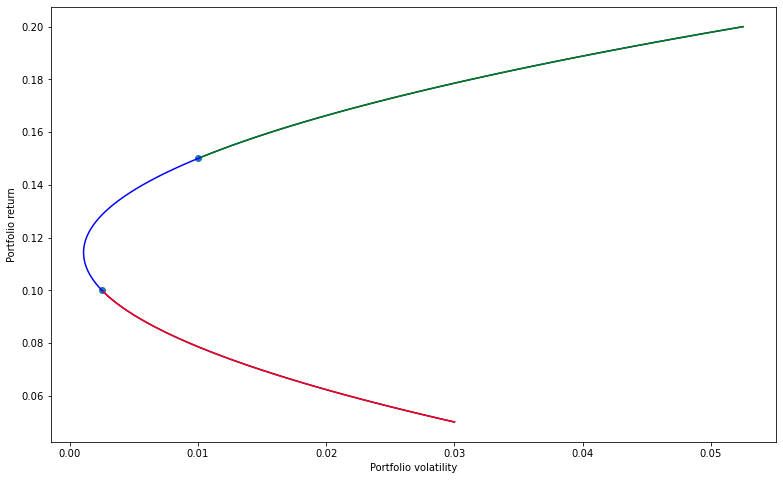

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(13, 8))
plt.plot(pf.sig2, pf.mu, color='b')
plt.plot(pf.sig2[pf.xa<0], pf.mu[pf.xa<0], color='r') # sell stock A to fund purchase of stock B
plt.plot(pf.sig2[pf.xb<0], pf.mu[pf.xb<0], color='g') # sell stock B to fund purchase of stock A
plt.scatter([A['sig']**2, B['sig']**2], [A['mu'], B['mu']])
ax.set_xlabel('Portfolio volatility')
ax.set_ylabel('Portfolio return')
plt.show(p)

* Line is called efficient frontier
* Represents the lower boundary of achievable volatility
* Return and volatility of $A$ and $B$

#### Long and short positions

* Note that `xa` can be negative
* Positive $x_A$ : _long position_ for stock A and indicates a purchase
* Negative $x_A$ : _short position_ stock A and indicates a sale
* _You are selling stocks that you do not own with the expectation that the price of the stock will fall_
* Shorting allows for higher long positions on other stocks.

#### Minimum variance portfolio (MVP)

What is the point at the tip of the parabola? This point indicates what is called the minimum variance portfolio that, regardless of the return, has the minimum volatility. Minimum variance portfolio (MVP) has the minimum volatility of any portfolio achievable.

It can be shown that minimum variance portfolio would have the following allocation $x_A$:

$$x_A = \frac{\sigma_B^2-\sigma_\text{AB}^2}{\sigma_A^2 + \sigma_B^2 – \sigma_\text{AB}^2}$$

The mathematical problem to solve for the minimum variance portfolio can be stated as follows:
$$ \min_{x_A,x_B}\ \ \sigma_p^2 = \sigma_A^2 x_A^2 + \sigma_B^2 x_B^2 + \sigma_{AB} x_A x_B\\
\text{such that }x_A + x_B = 1$$
Here, $\sigma_p^2 = \sigma_A^2 x_A^2 + \sigma_B^2 x_B^2 + \sigma_{AB} x_A x_B$ is called the objective function, and $x_A + x_B = 1$ is called the constraint.

The constraint has to be satisfied exactly, and objective wants to be minimized with the freedom of changing the values of $x_A$ and $x_B$.

### Using `cvxpy` for numerical optimization

Calculating analytical solutions is not always possible. There are ways to compute solutions numerically. Although out of scope of our class, a large field in applied math called optimization. The tools from this area allow us to compute solutions for problems such as the one we have here. (For more information, visit the 

### Higher dimensional portfolios

In higher dimensions, the portfolio equantion is written in terms of vectors and matrices. For example, suppose we construct a portfolio consisting of $s$-assets. The portfolio allocation can be written as,
$$\mathbf{1}^\intercal x = 1,$$
where $x$ is an $s$-vector whose sum adds up to 1: i.e., $x_1 + x_2 + \cdots + x_s = 1$.

The portfolio volatility in matrix-vector form looks like:
$$
\begin{pmatrix}x_1 & x_2 & \cdots & x_s\end{pmatrix}
\begin{pmatrix}
\sigma_1^2 & \sigma_{12} & \cdots & \sigma_{1s}\\
\sigma_{21} & \sigma_2^2 & \cdots & \sigma_{2s}\\
\vdots & \vdots & & \vdots \\
\sigma_{s1} & \sigma_{s2} & \cdots & \sigma_s^2\\
\end{pmatrix}
\begin{pmatrix}x_1 \\ x_2 \\ \vdots \\ x_s\end{pmatrix}.
$$
To verify the two stock example result, we check $\sigma_p^2$:
$$
\sigma_p^2 = \begin{pmatrix}x_1 & x_2\end{pmatrix}
\begin{pmatrix}
\sigma_1^2 & \sigma_{12}\\
\sigma_{21} & \sigma_2^2\\
\end{pmatrix}
\begin{pmatrix}x_1 \\ x_2\end{pmatrix} = 
\begin{pmatrix}x_1 & x_2\end{pmatrix}
\begin{pmatrix}
\sigma_1^2 x_1 + \sigma_{12} x_2\\
\sigma_{21} x_1 + \sigma_2^2 x_2\\
\end{pmatrix} = 
\sigma_1^2 x_1^2 + \sigma_2^2 x_2^2 + \sigma_{12} x_1 x_2,
$$
which matches the result from before.

With this notation, we can re-write the problem.

$$ \min_{x\in\mathbb{R}^s}\ \ x^\intercal \Sigma x\\
\text{subject to }\mathbf{1}^\intercal x = 1,$$

It can be shown that the optimal solution to this problem is,
$$ x^* = (\mathbf{1}^\intercal\Sigma^{-1}\mathbf{1})^{-1}\Sigma^{-1}\mathbf{1} $$.

There are many variations of this problem. In fact the minimum variance portfolio is special case of a more general problem

$$ \min_{x\in\mathbb{R}^s}\ \ x^\intercal \Sigma x\\
\text{subject to }\mu^\intercal x\geq \mu^* \text{, and } \mathbf{1}^\intercal x = 1,$$

Note that in all of the above problems, the measure of $\mu^*$, expected returns, and covariance matrix have to be provided. In practice, these quantities are estimated from data.

## Portfolio Allocation: Dow Jones component stocks

Stock data can have irregularities such as missing data due stocks being added and removed from the index. Some examples are
* Alcoa Corp. (AA) was removed in 2013
* Apple (AAPL) was added in 2015
* E.I. du Pont de Nemours & Company (DD) was removed and replaced with Dow du Pont (DWDP) as a continuation in 2017

For simplicity the stocks we will use are based on the most recent DJIA constituent companies 

In [11]:
dowjones_tickers = [
    'AAPL','AXP','BA','BAC','CAT',
    'CSCO','CVX','DD','DIS','GE',
    'HD','HPQ','IBM','INTC','JNJ',
    'JPM','KO','MCD','MMM',
    'MRK','MSFT','PFE','PG','T',
    'TRV','RTX','VZ','WMT','XOM'
]

import yfinance as yf

rawdata = yf.download(dowjones_tickers, start="2000-01-01", end="2020-05-10")
rawdata.head()

[*********************100%***********************]  29 of 29 completed


Adj Close                                                         \
                AAPL        AXP         BA        BAC        CAT       CSCO   
Date                                                                          
1999-12-31       NaN        NaN        NaN        NaN        NaN        NaN   
2000-01-03  0.860883  34.160576  25.940277  13.952057  13.693107  40.118656   
2000-01-04  0.788302  32.870731  25.899939  13.123939  13.517111  37.867947   
2000-01-05  0.799837  32.035824  27.513651  13.267960  13.833909  37.751926   
2000-01-06  0.730621  32.688519  27.796043  14.402134  14.537927  37.125427   

                                                        ...     Volume  \
                  CVX         DD        DIS         GE  ...        MRK   
Date                                                    ...              
1999-12-31        NaN        NaN        NaN        NaN  ...        NaN   
2000-01-03  19.360474  30.896286  23.115248  26.585829  ...  5978800.0   
2000-01-04  19.360474  30.051819  24.469286  25.522396  ...  7533100.0   
2000-01-05  19.707745  31.027334  25.484806  25.478096  ...  7598300.0   
2000-01-06  20.546988  31.900925  24.469286  25.818716  ...  4760500.0   

                                                                               \
                  MSFT         PFE         PG        RTX          T       TRV   
Date                                                                            
1999-12-31         NaN         NaN        NaN        NaN        NaN       NaN   
2000-01-03  53228400.0  12873345.0  4275000.0  3401096.0  5791900.0  336400.0   
2000-01-04  54119000.0  14208974.0  4270800.0  5350163.0  7173600.0  494400.0   
2000-01-05  64059600.0  12981591.0  5098400.0  6204409.0  9090000.0  736000.0   
2000-01-06  54976600.0  11115273.0  6524200.0  9770125.0  7153600.0  660400.0   

                                              
                   VZ        WMT         XOM  
Date                                          
1999-12-31        NaN        NaN         NaN  
2000-01-03  4663843.0  8369900.0  13458200.0  
2000-01-04  5005878.0  6745100.0  14510800.0  
2000-01-05  6368681.0  7018700.0  17485000.0  
2000-01-06  4705763.0  6544500.0  19461600.0  

[5 rows x 174 columns]

In [12]:
dowjones = yf.Tickers(dowjones_tickers)
symbols = [{'symbol':one, 'name':dowjones.tickers[one].info['shortName']} for one in dowjones.symbols]
symbols = pd.DataFrame(symbols).set_index('symbol')

In [13]:
symbols

,name
symbol,
AAPL,Apple Inc.
AXP,American Express Company
BA,Boeing Company (The)
BAC,Bank of America Corporation
CAT,"Caterpillar, Inc."
CSCO,"Cisco Systems, Inc."
CVX,Chevron Corporation
DD,"DuPont de Nemours, Inc."
DIS,Walt Disney Company (The)


## Data Format

### Hierarchical Indexing

* Column indexing is hierarchical
* Adjusted close, close, high, low, open, and volume are given for each stock symbol

In [14]:
rawdata.columns.levels

FrozenList([['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], ['AAPL', 'AXP', 'BA', 'BAC', 'CAT', 'CSCO', 'CVX', 'DD', 'DIS', 'GE', 'HD', 'HPQ', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'PFE', 'PG', 'RTX', 'T', 'TRV', 'VZ', 'WMT', 'XOM']])

* Column levels can be named:

In [15]:
rawdata.columns = rawdata.columns.set_names(['Value', 'Symbol'])
rawdata.head()

Value      Adj Close                                                         \
Symbol          AAPL        AXP         BA        BAC        CAT       CSCO   
Date                                                                          
1999-12-31       NaN        NaN        NaN        NaN        NaN        NaN   
2000-01-03  0.860883  34.160576  25.940277  13.952057  13.693107  40.118656   
2000-01-04  0.788302  32.870731  25.899939  13.123939  13.517111  37.867947   
2000-01-05  0.799837  32.035824  27.513651  13.267960  13.833909  37.751926   
2000-01-06  0.730621  32.688519  27.796043  14.402134  14.537927  37.125427   

Value                                                   ...     Volume  \
Symbol            CVX         DD        DIS         GE  ...        MRK   
Date                                                    ...              
1999-12-31        NaN        NaN        NaN        NaN  ...        NaN   
2000-01-03  19.360474  30.896286  23.115248  26.585829  ...  5978800.0   
2000-01-04  19.360474  30.051819  24.469286  25.522396  ...  7533100.0   
2000-01-05  19.707745  31.027334  25.484806  25.478096  ...  7598300.0   
2000-01-06  20.546988  31.900925  24.469286  25.818716  ...  4760500.0   

Value                                                                          \
Symbol            MSFT         PFE         PG        RTX          T       TRV   
Date                                                                            
1999-12-31         NaN         NaN        NaN        NaN        NaN       NaN   
2000-01-03  53228400.0  12873345.0  4275000.0  3401096.0  5791900.0  336400.0   
2000-01-04  54119000.0  14208974.0  4270800.0  5350163.0  7173600.0  494400.0   
2000-01-05  64059600.0  12981591.0  5098400.0  6204409.0  9090000.0  736000.0   
2000-01-06  54976600.0  11115273.0  6524200.0  9770125.0  7153600.0  660400.0   

Value                                         
Symbol             VZ        WMT         XOM  
Date                                          
1999-12-31        NaN        NaN         NaN  
2000-01-03  4663843.0  8369900.0  13458200.0  
2000-01-04  5005878.0  6745100.0  14510800.0  
2000-01-05  6368681.0  7018700.0  17485000.0  
2000-01-06  4705763.0  6544500.0  19461600.0  

[5 rows x 174 columns]

* Subsetting first level of hierarchical indexing: `Adj Close`

In [16]:
rawdata['Adj Close'].head()

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MRK,MSFT,PFE,PG,RTX,T,TRV,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,0.860883,34.160576,25.940277,13.952057,13.693107,40.118656,19.360474,30.896286,23.115248,26.585829,...,30.698004,37.017384,14.709098,30.248369,12.671476,15.941188,19.224304,20.573511,45.439945,20.760025
2000-01-04,0.788302,32.870731,25.899939,13.123939,13.517111,37.867947,19.360474,30.051819,24.469286,25.522396,...,29.619884,35.766914,14.161126,29.666332,12.151942,15.008461,18.969437,19.908472,43.739662,20.362385
2000-01-05,0.799837,32.035824,27.513651,13.267960,13.833909,37.751926,19.707745,31.027334,25.484806,25.478096,...,30.783119,36.144032,14.391850,29.101934,11.911183,15.241655,18.823801,20.573511,42.847008,21.472454
2000-01-06,0.730621,32.688519,27.796043,14.402134,14.537927,37.125427,20.546988,31.900925,24.469286,25.818716,...,31.038458,34.933285,14.911002,30.442392,12.481409,14.919894,19.187899,20.469007,43.314613,22.582546


* Subsetting first level of hierarchical indexing: `Volume`

In [17]:
rawdata.loc[:, 'Volume'].head()

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MRK,MSFT,PFE,PG,RTX,T,TRV,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,535796800.0,6471267.0,2638200.0,13705800.0,5055000.0,53076000.0,4387600.0,1296100.0,8402230.0,22952592.0,...,5978800.0,53228400.0,12873345.0,4275000.0,3401096.0,5791900.0,336400.0,4663843.0,8369900.0,13458200.0
2000-01-04,512377600.0,10440877.0,3592100.0,27293400.0,6181400.0,50805600.0,3702400.0,2073676.0,16051191.0,23006256.0,...,7533100.0,54119000.0,14208974.0,4270800.0,5350163.0,7173600.0,494400.0,5005878.0,6745100.0,14510800.0
2000-01-05,778321600.0,8646293.0,7631700.0,22855600.0,6398600.0,68524000.0,5567600.0,3653278.0,19823822.0,28384512.0,...,7598300.0,64059600.0,12981591.0,5098400.0,6204409.0,9090000.0,736000.0,6368681.0,7018700.0,17485000.0
2000-01-06,767972800.0,10990975.0,4922200.0,17307000.0,5140600.0,48242600.0,4353400.0,4885511.0,7903193.0,20668128.0,...,4760500.0,54976600.0,11115273.0,6524200.0,9770125.0,7153600.0,660400.0,4705763.0,6544500.0,19461600.0


* Subsetting second level is slightly harder: `AAPL`

In [18]:
idx = pd.IndexSlice
rawdata.loc[:, idx[:, 'AAPL']].head()

Value,Adj Close,Close,High,Low,Open,Volume
Symbol,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
1999-12-31,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,0.860883,0.999442,1.004464,0.907924,0.936384,535796800.0
2000-01-04,0.788302,0.915179,0.987723,0.903460,0.966518,512377600.0
2000-01-05,0.799837,0.928571,0.987165,0.919643,0.926339,778321600.0
2000-01-06,0.730621,0.848214,0.955357,0.848214,0.947545,767972800.0


* Subsetting `Open`, `High`, `Low`, and `Close` (OHLC) for `AAPL`:

In [19]:
aapl = rawdata.loc[:, idx['Close':'Open', 'AAPL']]
aapl.head()

Value,Close,High,Low,Open
Symbol,AAPL,AAPL,AAPL,AAPL
Date,,,,
1999-12-31,NaN,NaN,NaN,NaN
2000-01-03,0.999442,1.004464,0.907924,0.936384
2000-01-04,0.915179,0.987723,0.903460,0.966518
2000-01-05,0.928571,0.987165,0.919643,0.926339
2000-01-06,0.848214,0.955357,0.848214,0.947545


* Drop redudant index level, `AAPL`:

In [20]:
aapl = rawdata.loc[:, idx['Close':'Open', 'AAPL']].droplevel('Symbol', axis=1).tail(60)
aapl.head()

Value,Close,High,Low,Open
Date,,,,
2020-02-13,81.217499,81.555000,80.837502,81.047501
2020-02-14,81.237503,81.495003,80.712502,81.184998
2020-02-18,79.750000,79.937500,78.652496,78.839996
2020-02-19,80.904999,81.142502,80.000000,80.000000
2020-02-20,80.074997,81.162498,79.552498,80.657501


### Example Figure: Candlestick Chart for 3M

In [21]:
mmm = rawdata.loc[:, idx['Close':'Open', 'MMM']].droplevel('Symbol', axis=1).tail(60)

import altair as alt

open_close_color = alt.condition(
    "datum.Open <= datum.Close",
    alt.value("#06982d"), # green for increase
    alt.value("#ae1325"), # red for decrease
) 

base = alt.Chart(mmm.reset_index()).encode(
    alt.X('Date:T',
          axis=alt.Axis(
              format='%m-%d-%Y',
              labelAngle=-90)
    ),
    color=open_close_color
)

rule = base.mark_rule().encode(
    alt.Y(
        'Low:Q',
        title='Price',
        scale=alt.Scale(zero=False),
    ),
    alt.Y2('High:Q')
)

bar = base.mark_bar().encode(
    alt.Y('Open:Q'),
    alt.Y2('Close:Q')
)

rule + bar

alt.LayerChart(...)

### Example Figure: Adjusted close prices

In [22]:
first10 = rawdata.loc[:, idx['Adj Close', ['MMM', 'MRK', 'PFE', 'PG', 'UNH', 'JNJ']]].tail(60)
first10.head()

Value        Adj Close                                              
Symbol             JNJ         MMM        MRK        PFE          PG
Date                                                                
2020-02-13  145.212158  154.149353  78.755493  33.640732  121.161919
2020-02-14  145.250854  155.355453  79.408836  33.258137  122.306061
2020-02-18  144.293015  153.300278  79.226288  33.085056  121.074661
2020-02-19  144.099533  153.744095  78.784325  33.003075  121.627335
2020-02-20  143.548065  152.991501  79.255112  32.656918  122.732689

* Stacking transforms data into long-format:  
    _Note: unstack does the opposite_

In [23]:
healthcare = first10.stack('Symbol')
healthcare

Value               Adj Close
Date       Symbol            
2020-02-13 JNJ     145.212158
           MMM     154.149353
           MRK      78.755493
           PFE      33.640732
           PG      121.161919
...                       ...
2020-05-08 JNJ     144.784729
           MMM     143.294449
           MRK      74.010338
           PFE      34.242790
           PG      113.175537

[300 rows x 1 columns]

In [24]:
base = alt.Chart(healthcare.reset_index()).mark_line().encode(
    x=alt.X('Date:T',
            axis=alt.Axis(
                format='%m-%d-%Y',
                labelAngle=-90)
    ),
    y='Adj Close:Q',
    color='Symbol:N'
)
base

alt.Chart(...)

* Inspect missing values:  

In [25]:
rawdata['Adj Close'].isna().sum(axis=0)

Symbol
AAPL    2
AXP     2
BA      2
BAC     2
CAT     2
CSCO    2
CVX     2
DD      2
DIS     2
GE      2
HD      2
HPQ     2
IBM     2
INTC    2
JNJ     2
JPM     2
KO      2
MCD     2
MMM     2
MRK     2
MSFT    2
PFE     2
PG      2
RTX     2
T       2
TRV     2
VZ      2
WMT     2
XOM     2
dtype: int64

In [26]:
anymissing = rawdata['Adj Close'].isna().any(axis=1)
rawdata.loc[anymissing]

Value      Adj Close                                       ... Volume       \
Symbol          AAPL AXP  BA BAC CAT CSCO CVX  DD DIS  GE  ...    MRK MSFT   
Date                                                       ...               
1999-12-31       NaN NaN NaN NaN NaN  NaN NaN NaN NaN NaN  ...    NaN  NaN   
2001-09-12       NaN NaN NaN NaN NaN  NaN NaN NaN NaN NaN  ...    NaN  NaN   

Value                                       
Symbol     PFE  PG RTX   T TRV  VZ WMT XOM  
Date                                        
1999-12-31 NaN NaN NaN NaN NaN NaN NaN NaN  
2001-09-12 NaN NaN NaN NaN NaN NaN NaN NaN  

[2 rows x 174 columns]

* Raytheon bought United Technologies in April  
    Let's remove UTX and keep other recent data
* Remove missing day: '1999-12-31'
* Fill '2001-09-12', '2016-01-18' with [`pandas.DataFrame.fillna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html#pandas.DataFrame.fillna)

In [27]:
data_all = pd.concat([
    rawdata.loc[:, idx[:, :'TRV']], 
    rawdata.loc[:, idx[:, 'VZ':]], 
], axis=1).fillna(method='pad').loc['2000-01-03':]

data_all.columns = data_all.columns.set_names(['Value', 'Symbol'])

* Double check: did we remove all missing values?

In [28]:
(data_all.isna().sum(axis=None)>0).any()

False

* Reset symbols to what is in `data` variable

In [30]:
symbols = symbols.loc[data_all.columns.levels[1].to_list()]
symbols

,name
symbol,
AAPL,Apple Inc.
AXP,American Express Company
BA,Boeing Company (The)
BAC,Bank of America Corporation
CAT,"Caterpillar, Inc."
CSCO,"Cisco Systems, Inc."
CVX,Chevron Corporation
DD,"DuPont de Nemours, Inc."
DIS,Walt Disney Company (The)


In [31]:
data_all.head()

Value      Adj Close                                                         \
Symbol          AAPL        AXP         BA        BAC        CAT       CSCO   
Date                                                                          
2000-01-03  0.860883  34.160576  25.940277  13.952057  13.693107  40.118656   
2000-01-04  0.788302  32.870731  25.899939  13.123939  13.517111  37.867947   
2000-01-05  0.799837  32.035824  27.513651  13.267960  13.833909  37.751926   
2000-01-06  0.730621  32.688519  27.796043  14.402134  14.537927  37.125427   
2000-01-07  0.765229  33.164429  28.602896  14.024072  15.013142  39.306557   

Value                                                   ...      High  \
Symbol            CVX         DD        DIS         GE  ...       XOM   
Date                                                    ...             
2000-01-03  19.360474  30.896286  23.115248  26.585829  ...  40.37500   
2000-01-04  19.360474  30.051819  24.469286  25.522396  ...  39.09375   
2000-01-05  19.707745  31.027334  25.484806  25.478096  ...  40.87500   
2000-01-06  20.546988  31.900925  24.469286  25.818716  ...  42.90625   
2000-01-07  20.908724  32.614384  24.082424  26.818453  ...  43.12500   

Value             Low                          Open                    \
Symbol             VZ      WMT       XOM         VZ     WMT       XOM   
Date                                                                    
2000-01-03  53.622120  65.5000  38.93750  54.521442  68.375  39.75000   
2000-01-04  51.486229  64.1875  38.25000  53.678326  65.500  38.68750   
2000-01-05  52.610382  62.1875  38.90625  53.060043  63.875  39.00000   
2000-01-06  52.497967  62.6875  40.09375  53.678326  63.000  40.31250   
2000-01-07  51.992096  64.5000  42.00000  52.947628  64.500  42.96875   

Value          Volume                         
Symbol             VZ        WMT         XOM  
Date                                          
2000-01-03  4663843.0  8369900.0  13458200.0  
2000-01-04  5005878.0  6745100.0  14510800.0  
2000-01-05  6368681.0  7018700.0  17485000.0  
2000-01-06  4705763.0  6544500.0  19461600.0  
2000-01-07  5043907.0  7976900.0  16603800.0  

[5 rows x 174 columns]

### Adjusted Close

* [Adjusted closing prices](https://help.yahoo.com/kb/SLN28256.html) accounts for splits, etc

In [32]:
data = data_all['Adj Close']
data.head()

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MRK,MSFT,PFE,PG,RTX,T,TRV,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.860883,34.160576,25.940277,13.952057,13.693107,40.118656,19.360474,30.896286,23.115248,26.585829,...,30.698004,37.017384,14.709098,30.248369,12.671476,15.941188,19.224304,20.573511,45.439945,20.760025
2000-01-04,0.788302,32.870731,25.899939,13.123939,13.517111,37.867947,19.360474,30.051819,24.469286,25.522396,...,29.619884,35.766914,14.161126,29.666332,12.151942,15.008461,18.969437,19.908472,43.739662,20.362385
2000-01-05,0.799837,32.035824,27.513651,13.267960,13.833909,37.751926,19.707745,31.027334,25.484806,25.478096,...,30.783119,36.144032,14.391850,29.101934,11.911183,15.241655,18.823801,20.573511,42.847008,21.472454
2000-01-06,0.730621,32.688519,27.796043,14.402134,14.537927,37.125427,20.546988,31.900925,24.469286,25.818716,...,31.038458,34.933285,14.911002,30.442392,12.481409,14.919894,19.187899,20.469007,43.314613,22.582546
2000-01-07,0.765229,33.164429,28.602896,14.024072,15.013142,39.306557,20.908724,32.614384,24.082424,26.818453,...,34.017471,35.389793,15.920448,32.876366,12.975590,15.047773,19.952496,20.317860,46.587620,22.516262


### Log returns from stock prices

* Data is price per share
* We need daily returns from the prices
* Given the prices $P_t$ and $P_{t-1}$ for time $t$, the return is, 
$$ R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1 $$

* Approximation $\log(1+x)\approx x$ is good when $x$ is small
* Since daily returns of stocks are small, calculate as returns,
$$ r_t = \log(1 + R_t) = \log\left(\frac{P_t}{P_{t-1}}\right) = \log(P_t) - \log(P_{t-1})$$
So, in order to compute the log-returns, compute the difference of log prices:

In [33]:
logret = np.log(data).diff()
logret.head()

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MRK,MSFT,PFE,PG,RTX,T,TRV,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,-0.088077,-0.038490,-0.001556,-0.061189,-0.012936,-0.057736,0.000000,-0.027713,0.056926,-0.040822,...,-0.035752,-0.034364,-0.037966,-0.019429,-0.041864,-0.060292,-0.013346,-0.032859,-0.038136,-0.019340
2000-01-05,0.014527,-0.025728,0.060442,0.010914,0.023166,-0.003069,0.017778,0.031945,0.040664,-0.001737,...,0.038521,0.010489,0.016161,-0.019208,-0.020011,0.015418,-0.007707,0.032859,-0.020619,0.053082
2000-01-06,-0.090514,0.020169,0.010211,0.082024,0.049638,-0.016734,0.041703,0.027766,-0.040664,0.013281,...,0.008261,-0.034072,0.035437,0.045031,0.046763,-0.021337,0.019158,-0.005092,0.010854,0.050406
2000-01-07,0.046281,0.014454,0.028614,-0.026601,0.032165,0.057089,0.017452,0.022118,-0.015936,0.037991,...,0.091647,0.012983,0.065505,0.076918,0.038830,0.008535,0.039074,-0.007412,0.072845,-0.002940


* First time period is NaN since there is no data corresponding to $-1$.

* Note that $100\cdot r_t$% represent daily percentage returns.

### Estimate expected returns

Estimate the daily expected returns by computing the means:

In [34]:
mu = logret[1:].mean()
mu

Symbol
AAPL    0.000878
AXP     0.000185
BA      0.000320
BAC     0.000098
CAT     0.000406
CSCO    0.000007
CVX     0.000300
DD      0.000078
DIS     0.000303
GE     -0.000282
HD      0.000329
HPQ     0.000016
IBM     0.000094
INTC    0.000150
JNJ     0.000329
JPM     0.000243
KO      0.000204
MCD     0.000395
MMM     0.000322
MRK     0.000172
MSFT    0.000312
PFE     0.000165
PG      0.000258
RTX     0.000294
T       0.000108
TRV     0.000313
VZ      0.000191
WMT     0.000192
XOM     0.000141
dtype: float64

### Estimate covariance matrix (volatility structure)

Estimate the covarince matrix of returns:

In [35]:
sigma = logret.cov()
sigma

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MRK,MSFT,PFE,PG,RTX,T,TRV,VZ,WMT,XOM
Symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,0.000711,0.000221,0.000162,0.000240,0.000201,0.000297,0.000129,0.000171,0.000176,0.000196,...,0.000095,0.000229,0.000093,0.000067,0.000160,0.000120,0.000142,0.000104,0.000101,0.000121
AXP,0.000221,0.000524,0.000242,0.000445,0.000255,0.000251,0.000198,0.000271,0.000246,0.000284,...,0.000147,0.000215,0.000152,0.000111,0.000230,0.000169,0.000239,0.000148,0.000129,0.000176
BA,0.000162,0.000242,0.000447,0.000250,0.000205,0.000180,0.000172,0.000224,0.000188,0.000212,...,0.000114,0.000165,0.000120,0.000090,0.000231,0.000122,0.000166,0.000101,0.000098,0.000156
BAC,0.000240,0.000445,0.000250,0.000849,0.000296,0.000266,0.000221,0.000322,0.000249,0.000335,...,0.000153,0.000220,0.000171,0.000119,0.000237,0.000180,0.000276,0.000153,0.000126,0.000192
CAT,0.000201,0.000255,0.000205,0.000296,0.000421,0.000203,0.000187,0.000274,0.000185,0.000223,...,0.000115,0.000176,0.000125,0.000093,0.000210,0.000129,0.000167,0.000110,0.000106,0.000172
CSCO,0.000297,0.000251,0.000180,0.000266,0.000203,0.000596,0.000137,0.000199,0.000212,0.000223,...,0.000103,0.000271,0.000115,0.000081,0.000184,0.000139,0.000165,0.000131,0.000118,0.000130
CVX,0.000129,0.000198,0.000172,0.000221,0.000187,0.000137,0.000300,0.000193,0.000150,0.000167,...,0.000118,0.000142,0.000114,0.000078,0.000157,0.000116,0.000154,0.000099,0.000072,0.000228
DD,0.000171,0.000271,0.000224,0.000322,0.000274,0.000199,0.000193,0.000509,0.000201,0.000237,...,0.000133,0.000170,0.000136,0.000111,0.000219,0.000141,0.000187,0.000118,0.000113,0.000177
DIS,0.000176,0.000246,0.000188,0.000249,0.000185,0.000212,0.000150,0.000201,0.000370,0.000199,...,0.000111,0.000174,0.000113,0.000083,0.000177,0.000131,0.000153,0.000122,0.000102,0.000138


### Visualize volatility structure

* Heatmap visualization of covariance and correlation

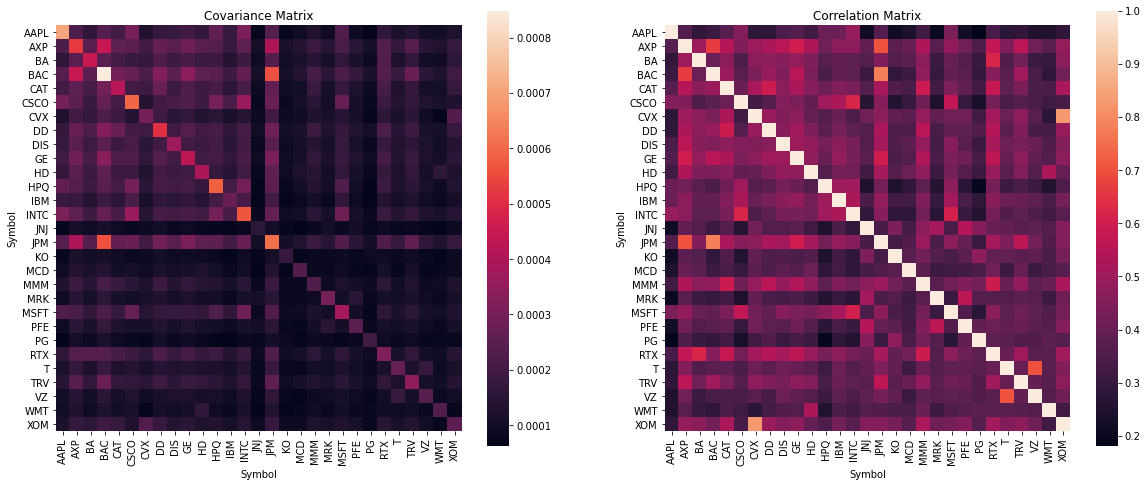

In [36]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(logret.cov(),  square=True, ax=ax[0]).set_title('Covariance Matrix')
sns.heatmap(logret.corr(), square=True, ax=ax[1]).set_title('Correlation Matrix')
fig.show()

* Reordering variables group similar stocks together

/opt/conda/lib/python3.8/site-packages/seaborn/matrix.py:1216: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


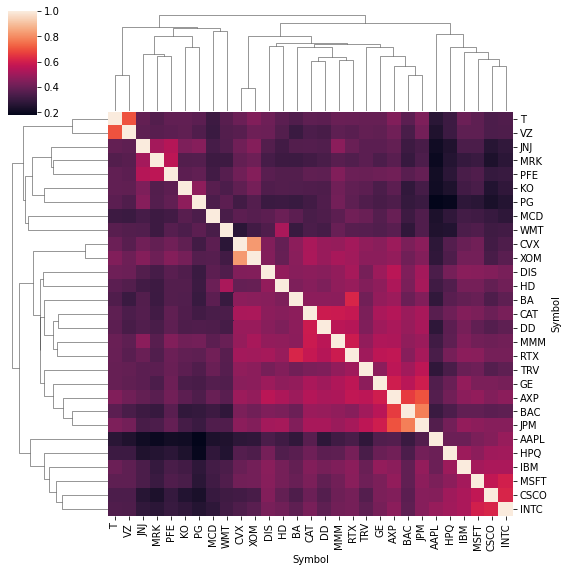

In [37]:
clmap = sns.clustermap(logret.corr(), square=True, figsize=(8, 8));
ordering = clmap.dendrogram_col.reordered_ind # save the hierarchical clustering generated variable ordering

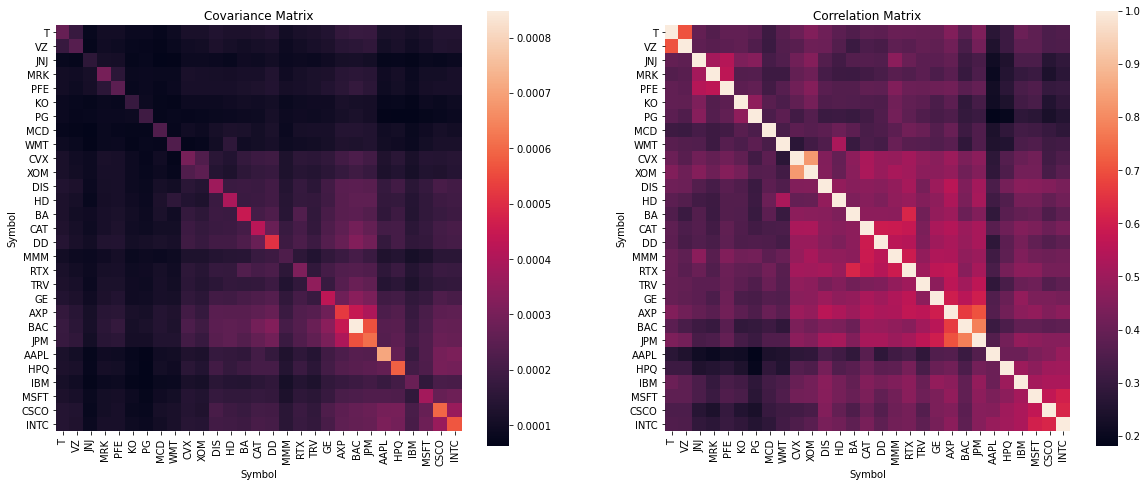

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(logret.cov().iloc[ordering, ordering],  square=True, ax=ax[0]).set_title('Covariance Matrix')
sns.heatmap(logret.corr().iloc[ordering, ordering], square=True, ax=ax[1]).set_title('Correlation Matrix')
fig.show()

## Calculate Minimum Variance Portfolio

* $\Sigma$ matrix is all that is specified
* $\Sigma$ characterizes the market
* Minimize variance of portfolio $R_p$

In [39]:
import cvxpy as cvx

s, _ = sigma.shape # calculated from data

w = cvx.Variable(s) # variables
risk = cvx.quad_form(w, sigma.values)  # objective function
prob = cvx.Problem(cvx.Minimize(risk), # optimization problem 
               [cvx.sum(w) == 1])      # fully invested portfolio constraint
prob.solve()

8.69850040494734e-05

In [40]:
w.value

array([ 0.02016334, -0.07536345, -0.00730124, -0.01009793, -0.01105981,
       -0.01636699,  0.04295917, -0.04174601,  0.01089446, -0.01453842,
       -0.02252525,  0.01437234,  0.11139676, -0.02360143,  0.22001218,
       -0.0337635 ,  0.15639304,  0.1452732 ,  0.09435745,  0.00396304,
        0.01467289,  0.03230781,  0.12335983,  0.00212344,  0.00699251,
        0.01409796,  0.10007964,  0.13065128,  0.01229369])

* Positive weights indicate long positions
* Negative weights indicate [short positions](https://en.wikipedia.org/wiki/Short_(finance))
* Must sum to 1 (constraint)

* Other portfolio optimization variations:  
    http://nbviewer.jupyter.org/github/cvxgrp/cvx_short_course/blob/master/applications/portfolio_optimization.ipynb

* `cvxpy` package makes it easy to solve many types of problems easily
* Portfolio allocation problem with target expected return constraint:

$$ \min_{x\in\mathbb{R}^s}\ \ x^\intercal \Sigma x\\
\text{subject to }\mu^\intercal x\geq \mu^* \text{, and } \mathbf{1}^\intercal x = 1,$$

* Expected returns, $\mu$, is estimated from data (also $\Sigma$)
* Investor specifies target return $\mu^*$

In [41]:
import cvxpy as cvx

s,_ = sigma.shape

w = cvx.Variable(s)
risk = cvx.quad_form(w, sigma.values)
prob = cvx.Problem(cvx.Minimize(risk), 
               [
                   cvx.sum(w) == 1,
                   mu.values@w >= 0.001
               ])
prob.solve()

0.00021275112901609534

In [42]:
w.value

array([ 0.2841767 , -0.0940328 ,  0.05604708, -0.08059854,  0.16044698,
       -0.1409541 ,  0.29567286, -0.15231747,  0.10228465, -0.46383075,
        0.05471487, -0.10316639, -0.00421006, -0.07644903,  0.43554727,
        0.11727412,  0.02891495,  0.2819079 ,  0.27414413, -0.06723333,
        0.10185588, -0.02663443,  0.15521546,  0.05576415, -0.13489514,
        0.0811047 ,  0.16473644,  0.02944092, -0.33492702])

* Higher target return achieved with more short positions
* Constraint: $\mu^\intercal w=0.001$
* Constraint: $\mathbf{1}^\intercal w=1$.

In [43]:
w.value.sum()

1.0000000000000002

In [44]:
np.dot(mu.values,w.value)

0.0010000000000000002

### Making the investment

* Investing 1 dollar in a stock with 3% return over one time period makes me 3 cents:  
    $$\$1 \cdot (1 + 0.03) = 1.03$$
    
* Investing a portfolio of worth $A_0$ dollars returns,
    $$ A = A_0 (1+r_t^T w_t), $$
    where elements of $r_t$ are returns at time $t$ and $w$ is portfolio allocation

* Take allocation `w.value` and compute portfolio returns using historical returns: `logret`.

In [45]:
earned = np.dot(logret.fillna(method='bfill').values, w.value)

* Compute portfolio growth

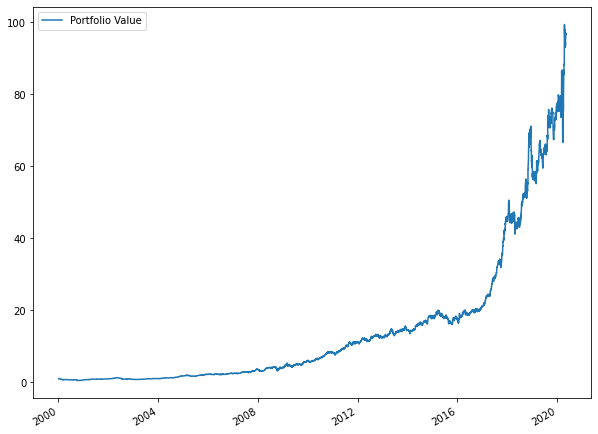

In [46]:
earnedcp = (1+earned[1:]).cumprod()
ecp = pd.DataFrame(data=earnedcp.T, index=logret.index.values[1:], columns=['Portfolio Value'])
ecp.plot(figsize=(10, 8));

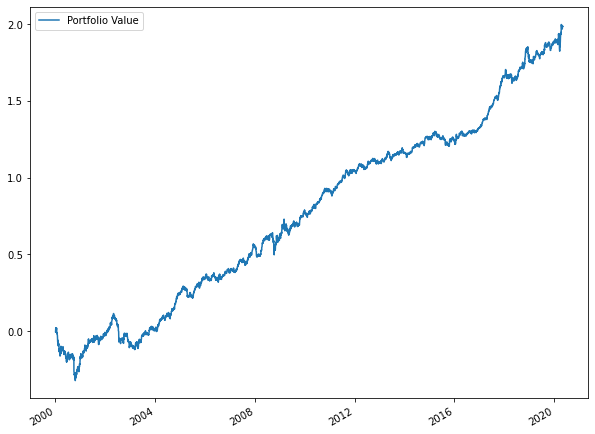

In [47]:
np.log10(ecp).plot(figsize=(10, 8));

In [48]:
ecp

,Portfolio Value
2000-01-04,0.993205
2000-01-05,1.007352
2000-01-06,1.014581
2000-01-07,1.053586
2000-01-10,1.025508
...,...
2020-05-04,95.695901
2020-05-05,96.248089
2020-05-06,96.518126
2020-05-07,97.015461


* 1 dollar invested in 2000 would be 98 dollars today?
* Unrealistic! Why?
* Having knowledge of 20 years worth of data is cheating!

### Quantify results

In [49]:
retinfo = logret.mean(axis=0).agg(['min', 'mean', 'max'])
stdinfo = logret.std(axis=0).agg(['min', 'mean', 'max'])
print('portfolio average returns:', earned.mean())
print('          average stddev :', earned.std())
print('')
print("component stocks average: minimum: %f\n                          average: %f\n                          maximum: %f" % tuple(retinfo))
print("component stocks stddev : minimum: %f\n                          average: %f\n                          maximum: %f" % tuple(stdinfo))

portfolio average returns: 0.000998477905408937
          average stddev : 0.014583548992173723

component stocks average: minimum: -0.000282
                          average: 0.000225
                          maximum: 0.000878
component stocks stddev : minimum: 0.012458
                          average: 0.019161
                          maximum: 0.029132


Annual return would be:

In [50]:
(1+earned.mean())**365 - 1

0.4394521814207102

Again, unrealistic

### Qualitative Visualization of Relationships

* Correlations are stricly pairwise quantities (what about other stocks?)
* Inverse covariance

In [51]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(logret.dropna().values)
scaled_df = pd.DataFrame(scaled_df, columns=logret.columns, index=logret.index[1:])

#### Correlation Matrix: 2020

/opt/conda/lib/python3.8/site-packages/seaborn/matrix.py:1216: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


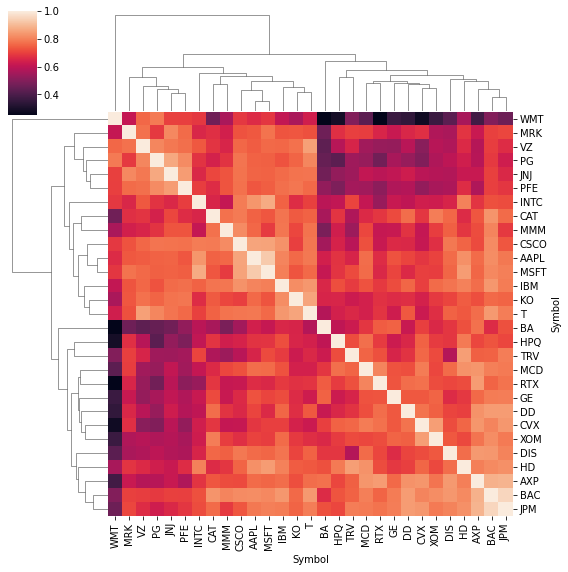

In [52]:
clmap = sns.clustermap(scaled_df.loc['2020':'2020'].corr(), square=True, figsize=(8, 8));
ordering = clmap.dendrogram_col.reordered_ind # save the hierarchical clustering generated variable ordering

#### Correlation Matrix: 2019 vs. 2020

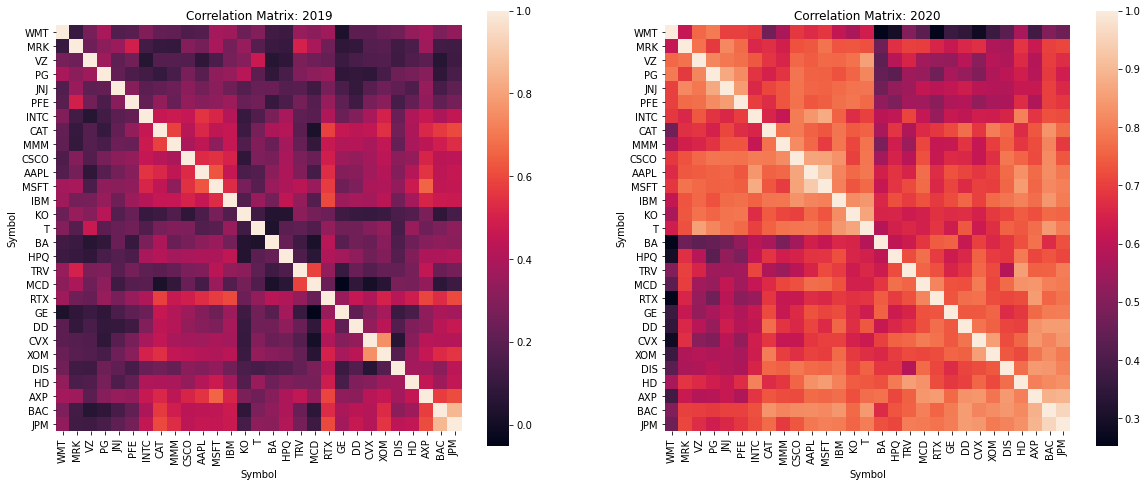

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(scaled_df.loc['2019':'2019'].corr().iloc[ordering, ordering],  square=True, ax=ax[0]).set_title('Correlation Matrix: 2019')
sns.heatmap(scaled_df.loc['2020':'2020'].corr().iloc[ordering, ordering],  square=True, ax=ax[1]).set_title('Correlation Matrix: 2020')
fig.show()

### Reality check

Obviously, this cannot be realistic. What aspects were unrealistic?

1. We didn't take time into consideration: e.g. estimation of $\Sigma$ and selecting `w`.
1. We are investing with knowledge of the future returns!
1. We did not take into account transaction costs (we will have to) 
1. We did not take into account shorting requires borrowing of money
1. Is investing in stocks better than leaving our money in a savings account? What is the interest rate?

Sharpe ratio tries to quantify the added benefit, i.e., excess returns, of investing in the volatile market by accounting for the volatility:
$$\text{Sharpe ratio}=\frac{E\left[R_{p}-R_{f}\right]}{\sigma_{p}}$$
where $R_f$ is the risk-free rate.

### Other considerations

1. Picking component stocks (choosing what to invest in)
    1. Playing the role of the fund manager
    1. Expertise about a specific market
    1. Warren Buffet says stick with long term _value_ investing strategies
    1. High-frequency trading makes money by constantly shuffling investments and making incremental returns
    1. Where is the middle ground? i.e., choosing strategies
1. Choosing monitoring strategies (keeping an eye out for changes in the market)
    1. Estimation of $\Sigma$ becomes challenging with shorter historical data
    1. "Regularized" estimates of $\Sigma$: Ledoit-Wolfe, Condition number, Sparsity inducing, Low-rank
    1. How big of a change in the market is signficant change?
    1. Where to look for a change? Component stocks? Market indices? Economic indicators? Consumer sentiment? Policy changes?
    1. Deciding when to take action. How big of a change warrants an action? (Actions cost money)
1. Choosing rebalancing strategy (deciding when to shuffle your investments)  
    1. Fixed intervals? dynamic intervals? 
    1. Allowing for shorts?
    1. If many component stocks, do you trade all of them even if the change is small? etc.

## Other optimization problems for modeling and learning

1. [Online advertising](https://github.com/UCSB-PSTAT-134-234/Spring2019/blob/master/labs/lab05/lab05.ipynb)
1. [Trend filtering](https://web.stanford.edu/~boyd/l1_tf/), [CVX example](https://www.cvxpy.org/examples/applications/l1_trend_filter.html)
1. [Catching a smuggler](https://www.cvxpy.org/examples/applications/interdiction.html)
1. [Estimating sparse inverse covariance matrix](https://www.cvxpy.org/examples/applications/sparse_covariance_est.html)
1. [Max-flow, Min-cut problem](https://www.cvxpy.org/examples/applications/OOCO.html)
1. Many more!!